# Car Purchase Dollar Amount Challenge
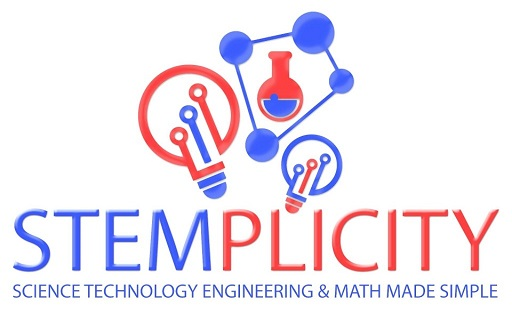

You are working as a car salesman and you would like to develop a model to predict the total dollar amount that customers are willing to pay.

In this challenge, we have a dataset of 500 records containing information about:

    •  Customer Name
    •  Customer e-mail
    •  Country
    •  Gender
    •  Age
    •  Annual Salary 
    •  Credit Card Debt 
    •  Net Worth 

#### **Main Objective**: The main objective is to build a regressor for the target variable "Car Purchase Amount".

## Table of Contents

1. [Import Libraries](#1)
2. [Import Data](#2)
    - 2.1. [Data Visualization](#2.1)
3. [Feature Analysis & Feature Engineering](#3)
    - 3.1. [Outlier Detection](#3.1)
    - 3.2. [Uninformative Features](#3.2)
    - 3.3. [Age Column](#3.3)
    - 3.4. [Country Column](#3.4)
4. [One Hot Encoding](#4)
5. [Feature Selection](#5)
6. [Train Test Split](#6)
7. [Data Normalization](#7)
8. [Model Training](#8)
9. [Model Evaluation](#9)

# STEP #1: Import Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry as pc
import pycountry_convert as pcc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense

#to get reproducible results
from numpy.random import seed
seed(1)
tf.keras.utils.set_random_seed(2)

# STEP #2: Import Data

In [ ]:
car_df = pd.read_csv('./data/Car_Purchasing_Data.csv', encoding='ISO-8859-1')
car_df.head()


In [ ]:
car_df.shape

## STEP #2.1: Data Visualization

In [ ]:
sns.pairplot(car_df)

# STEP #3: Feature Analysis & Feature Engineering
## STEP #3.1: Remove Outliers

In [ ]:
def IQR_OutlierRemover(df,column,n):
    #give the function the column that you want to filter and the IQR multiplicator    
    # Compute the IQR
    q1= df[column].quantile(0.25)
    q3= df[column].quantile(0.75)
    Iqr = q3 - q1

    # Compute upper and lower limit (lower_limit = Q1 -1.5*IQR | upper_limit = Q3 + 1.5*IQR)
    lower_lim = q1 - n*Iqr
    upper_lim = q3 + n*Iqr

    initial_len = df.shape[0]

    df = df[~((df[column] < lower_lim) | (df[column] > upper_lim))]

    len_afterremov = df.shape[0]

    print(f'Percentage of data kept after removing outliers in column {column}:', np.round(len_afterremov / initial_len * 100, 4),'%')

    return df

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(12, 5),constrained_layout=True)

axes[0].boxplot("Age",data=car_df)
axes[0].set_title('Age')

axes[1].boxplot("Annual Salary",data=car_df)
axes[1].set_title('Annual Salary')

axes[2].boxplot("Credit Card Debt",data=car_df)
axes[2].set_title('Credit Card Debt')

axes[3].boxplot("Net Worth",data=car_df)
axes[3].set_title('Net Worth')

plt.suptitle('Presence of Outliers in numeric features', fontsize=16)
plt.show()

In [ ]:
car_df_nooutliers = car_df.copy()
car_df_nooutliers = IQR_OutlierRemover(car_df_nooutliers,'Age',1.5)
car_df_nooutliers = IQR_OutlierRemover(car_df_nooutliers,'Annual Salary',1.5)
car_df_nooutliers = IQR_OutlierRemover(car_df_nooutliers,'Credit Card Debt',1.5)
car_df_nooutliers = IQR_OutlierRemover(car_df_nooutliers,'Net Worth',1.5)
#car_df = IQR_OutlierRemover(car_df,'player_level',1.5)
print('\n')
print("Percentage of data kept after total outlier removal:",car_df_nooutliers.shape[0]/car_df.shape[0] * 100,"%")

In [ ]:
car_df = car_df_nooutliers.copy()

## STEP #3.2: Uninformative Features

In [ ]:
car_df.drop(['Customer Name','Customer e-mail'], axis=1, inplace=True)
car_df.head()

## STEP #3.3: Age Column

In [ ]:
#Round the Age column
car_df['Age'] = car_df['Age'].round(0).astype('int')
car_df.head()

## STEP #3.4: Country Column 

In [ ]:
#with this function we convert the country name into the continent code 
#doing this I realize that are countries (super small ones!) that are not in the library pycountry_convert (Ex. Sint Maarten)
# so I drop all the columns of people with unknown countries

def country_to_continent(country_name):
    country_alpha2 = pcc.country_name_to_country_alpha2(country_name)
    if country_alpha2 == 'AQ':
        country_continent_code = 'AQ'
    else:
        country_continent_code = pcc.country_alpha2_to_continent_code(country_alpha2)
    return country_continent_code

car_df.loc[car_df['Country'] == 'Sint Maarten', 'Country'] = "Curaçao"
car_df.loc[car_df['Country'] == 'Timor-Leste', 'Country'] = "Indonesia"
car_df.loc[car_df['Country'] == 'Reunion', 'Country'] = "Madagascar"
car_df.loc[car_df['Country'] == 'United States Minor Outlying Islands', 'Country'] = "United States of America"
car_df.loc[car_df['Country'] == 'Heard Island and Mcdonald Islands', 'Country'] = "Australia"
car_df.loc[car_df['Country'] == 'Congo (Brazzaville)', 'Country'] = "Congo"
car_df.loc[car_df['Country'] == 'Virgin Islands, United States', 'Country'] = "United States of America"
car_df.loc[car_df['Country'] == 'French Southern Territories', 'Country'] = "Australia"
car_df.loc[car_df['Country'] == 'Saint Vincent and The Grenadines', 'Country'] = "Venezuela"
car_df.loc[car_df['Country'] == 'Western Sahara', 'Country'] = "Morocco"
car_df.loc[car_df['Country'] == 'United Kingdom (Great Britain)', 'Country'] = "United Kingdom"
car_df.loc[car_df['Country'] == 'South Georgia and The South Sandwich Islands', 'Country'] = "Argentina"
car_df.loc[car_df['Country'] == 'Korea, South', 'Country'] = "South Korea"
car_df.loc[car_df['Country'] == 'marlal', 'Country'] = "Kenya"

car_df['Continent'] = car_df['Country'].apply(lambda x: country_to_continent(x))

car_df.drop(['Country'], axis=1, inplace=True)

car_df.head()

# STEP #4: One Hot Encoding

In [ ]:
car_df = pd.get_dummies(car_df,'Continent', drop_first=True)
car_df.head()

# STEP #5: FEATURE SELECTION
Feature Selection is the preprocessing step that selects the input variables that are most important to your Machine Learning task.

To perform that let's use the correlation matrix. This table displays the correlation coefficients for different variables. The matrix presents the correlation between all the possible pairs of values in a table. 

It is a powerful tool to summarize a large dataset and to identify and visualize patterns in the given data.

**Rule of thumb**: Drop columns with high correlation (>0.95) 

In [ ]:
# Compute the correlation matrix
corr = car_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True).set(title='Feature Correlation')

# STEP #6: TRAIN TEST SPLIT

In [ ]:
X = car_df.drop('Car Purchase Amount',axis='columns')
y = car_df['Car Purchase Amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP #7: DATA NORMALIZATION

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [ ]:
y_scaler = MinMaxScaler()
y_train = y_train.values.reshape(-1,1)
y_train = y_scaler.fit_transform(y_train)

# STEP #8: MODEL TRAINING

In [ ]:
model = Sequential()
model.add(Dense(25, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
epochs_hist = model.fit(X_train, y_train, epochs=1000, batch_size=32,  verbose=1, validation_split=0.1,callbacks=[callback])

# STEP #9: EVALUATING THE MODEL 

In [ ]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])

plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Training and Validation Losses')
plt.xlabel('Epoch Number')
plt.legend(['Training Loss', 'Validation Loss'])

In [ ]:
X_test = scaler.transform(X_test)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = y_scaler.inverse_transform(y_pred)

In [ ]:
from sklearn.metrics import r2_score
print('R2 SCORE:',r2_score(y_test, y_pred))
print('Adjusted R2 SCORE:',1-(1-r2_score(y_test, y_pred))*(486-1)/(486-12-1))

In [ ]:
#from sklearn.metrics import mean_squared_error
#import math
#print(mean_squared_error(y_test, y_pred))
#print(math.sqrt(mean_squared_error(y_test, y_pred)))